### Подключение к базе данных

In [ ]:
!pip3 install psycopg2-binary

In [ ]:
pip install loguru

In [ ]:
pip install --upgrade 'sqlalchemy<2.0'

In [66]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

from sqlalchemy import text
from sqlalchemy import create_engine
#from loguru import logger

age	Возраст пользователя (в профиле)  
city	Город пользователя (в профиле)  
country	Страна пользователя (в профиле)  
exp_group	Экспериментальная группа: некоторая зашифрованная категория  
gender	Пол пользователя  
id	Уникальный идентификатор пользователя  
os	Операционная система устройства, с которого происходит пользование соц.сетью  
source	Пришел ли пользователь в приложение с органического трафика или с рекламы

In [36]:
### Необходимо по user_id выделять 
### Фиксированный набор признаков
### В целом, подойдет оригинальный датасет

user = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)
user.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [37]:
user.user_id.nunique()

163205

In [2]:
posts = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)
posts.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
posts.shape

(7023, 3)

timestamp	Время, когда был произведен просмотр  
user_id	id пользователя, который совершил просмотр  
post_id	id просмотренного поста  
action	Тип действия: просмотр или лайк  
target	1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение.

In [ ]:
def batch_load_sql(query: str):
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
        logger.info(f"Got chunk: {len(chunk_dataframe)}")
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [ ]:
feed = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed.head()

In [4]:
feed= pd.read_csv('/kaggle/input/feeddata/proj_3.csv')
feed.head()

,timestamp,user_id,post_id,action,target
0,2021-12-02 14:56:08,157752,2958,view,0
1,2021-12-02 14:57:57,157752,7219,view,0
2,2021-12-02 14:58:57,157752,1371,view,0
3,2021-12-02 15:00:06,157752,187,view,0
4,2021-12-02 15:03:02,157752,2069,view,0


In [5]:
feed.user_id.nunique()

2155

In [6]:
feed.shape

(1000000, 5)

In [7]:
feed[feed.action == "like"].user_id.nunique()

2154

In [8]:
feed[feed.action == "like"].sort_values(by='post_id')[:4]

,timestamp,user_id,post_id,action,target
326596,2021-10-04 21:18:24,164248,1,like,0
251811,2021-11-23 08:28:06,157796,1,like,0
823710,2021-11-02 13:28:10,138716,1,like,0
571084,2021-11-08 06:39:09,110496,1,like,0


### Работа с данными и фичи для контентной модели

In [9]:
feed = feed[feed.action=='view'] 

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocessing(df, doc='text'):
    #string.punctuation = '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
    #the first is a pattern to search, the second is by which we have to replace, 
    #and the third is string or text which we have to change.
    
    #'[%s]' % re.escape(string.punctuation) заменяется на ''
    df[doc] = df[doc].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    df[doc] = df[doc].apply(lambda x: " ".join([word for word in str(x).split() if word not in stop_words]))
    #" ".join - слова в списке соединить в предложение через пробел
    #.split() - разбить строку на слова, список из строк
    df[doc] = df[doc].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
    return df


In [ ]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

In [16]:
posts = preprocessing(posts)

In [12]:
#nltk.download('wordnet', download_dir = '/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...


True

In [13]:
#nltk.data.path.append('/kaggle/input/corpora/wordnet')

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(stop_words = 'english')
doc = tf_idf.fit_transform(posts['text'])

In [18]:
tf_idf_matrix = doc.todense()

In [19]:
tf_idf_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
df = pd.DataFrame(tf_idf_matrix, 
                 columns = tf_idf.get_feature_names_out())

In [21]:
df.head()

,00,000,0000,0001,00051,001,002,003,004secs,007,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063052,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df.shape

(7023, 60909)

In [23]:
posts['SUM_tfidf'] = df.apply(lambda x:sum(x), axis = 1).reset_index()[0]
posts['MAX_tfidf'] = df.max(axis = 1).reset_index()[0]
posts['MEAN_tfidf'] = df.mean(axis = 1).reset_index()[0]

In [24]:
scaler_df = df-df.mean()

In [25]:
df = pd.DataFrame(scaler_df, 
                 columns = tf_idf.get_feature_names_out())

In [26]:
df[:3]

,00,000,0000,0001,00051,001,002,003,004secs,007,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
0,-0.000081,-0.000024,-0.000047,-0.000009,-0.000008,-0.00001,-0.000012,-0.000018,-0.000019,-0.000158,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
1,-0.000081,-0.000024,-0.000047,-0.000009,-0.000008,-0.00001,-0.000012,-0.000018,-0.000019,-0.000158,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
2,-0.000081,-0.000024,-0.000047,-0.000009,-0.000008,-0.00001,-0.000012,0.063034,-0.000019,-0.000158,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003


In [27]:
### Пытаемся кластеризовать тексты
pca = PCA(n_components=15)
PCA_dataset = pca.fit_transform(df)
PCA_dataset = pd.DataFrame(PCA_dataset, columns = [f'PCA_{i}' for i in np.arange(1, 16)])
PCA_dataset

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
0,-0.138718,0.112152,0.002539,-0.106017,-0.143266,0.245570,-0.057802,0.145302,-0.084609,0.092909,0.040134,-0.013979,-0.030905,-0.012353,-0.012097
1,-0.132720,0.149872,0.038555,0.029806,-0.030531,0.032337,0.010676,0.015764,0.010698,-0.011442,0.017470,-0.002532,-0.008056,-0.036128,0.055803
2,-0.098918,0.059957,-0.002806,-0.098787,-0.112111,0.157991,-0.057962,0.023127,-0.000379,-0.012417,-0.013090,-0.015118,0.015890,-0.021916,0.009974
3,-0.105471,0.049759,0.005614,-0.060386,-0.091041,0.069819,-0.022340,-0.032067,0.052558,-0.044297,-0.012157,-0.014102,0.023421,0.001125,-0.000431
4,-0.070926,0.017792,0.003758,-0.030225,-0.024774,0.013346,0.004798,-0.054141,0.025383,-0.041254,-0.032272,-0.030175,-0.000139,0.001386,-0.015530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,0.171185,0.015269,0.139419,-0.027335,-0.001928,-0.005961,-0.004781,0.004385,-0.004092,-0.002253,0.030463,-0.007428,0.017706,-0.023225,-0.007795
7019,0.157063,0.013116,0.088255,-0.009916,-0.034479,-0.001694,0.018151,0.022333,0.023541,0.021390,-0.022086,0.003482,0.017861,0.014508,-0.019796
7020,0.068027,-0.009307,-0.121657,0.061519,-0.026675,-0.010643,-0.035842,0.005558,0.023975,0.012307,0.002305,0.014619,0.016293,0.025688,0.010176
7021,0.059826,0.005935,-0.100172,0.044872,-0.020522,0.000580,0.002613,-0.002414,-0.005374,0.010083,-0.024864,0.007060,-0.006208,0.011350,0.005489


In [28]:
from sklearn.cluster import KMeans
km =  KMeans(n_clusters = 10, random_state=0).fit(PCA_dataset)
data_km = km.transform(PCA_dataset)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
km_pca_dataset = pd.DataFrame(data = data_km, columns=[f'dist_{i}_claster' for i in np.arange(1, 11)])

In [30]:
posts['claster_KMean'] = km.labels_

In [31]:
km_pca_dataset

,dist_1_claster,dist_2_claster,dist_3_claster,dist_4_claster,dist_5_claster,dist_6_claster,dist_7_claster,dist_8_claster,dist_9_claster,dist_10_claster
0,0.448732,0.462001,0.140072,0.425842,0.482200,0.512864,0.435103,0.387660,0.470212,0.438718
1,0.293834,0.308159,0.241982,0.249473,0.336160,0.240547,0.264213,0.145659,0.330775,0.278108
2,0.313276,0.326590,0.104375,0.270953,0.351131,0.446035,0.306911,0.214393,0.370694,0.310855
3,0.252363,0.282626,0.210448,0.210737,0.312307,0.392650,0.241368,0.113341,0.324547,0.271547
4,0.195716,0.229864,0.278022,0.125108,0.259923,0.364872,0.223796,0.094624,0.272801,0.217990
...,...,...,...,...,...,...,...,...,...,...
7018,0.314254,0.266155,0.406738,0.236920,0.074705,0.458258,0.357405,0.311293,0.382695,0.323750
7019,0.286253,0.213503,0.382854,0.210124,0.057195,0.441160,0.321826,0.287362,0.339367,0.309179
7020,0.247783,0.063684,0.368334,0.173654,0.251438,0.428543,0.305851,0.252852,0.302215,0.273819
7021,0.235485,0.055620,0.342367,0.134521,0.224187,0.404375,0.283763,0.228476,0.256253,0.252609


In [32]:
posts = pd.concat([posts, km_pca_dataset], axis = 1)
posts

,post_id,text,topic,SUM_tfidf,MAX_tfidf,MEAN_tfidf,claster_KMean,dist_1_claster,dist_2_claster,dist_3_claster,dist_4_claster,dist_5_claster,dist_6_claster,dist_7_claster,dist_8_claster,dist_9_claster,dist_10_claster
0,1,UK economy facing major risk The UK manufactur...,business,8.758287,0.490607,0.000144,2,0.448732,0.462001,0.140072,0.425842,0.482200,0.512864,0.435103,0.387660,0.470212,0.438718
1,2,Aids climate top Davos agenda Climate change f...,business,12.459278,0.252258,0.000205,7,0.293834,0.308159,0.241982,0.249473,0.336160,0.240547,0.264213,0.145659,0.330775,0.278108
2,3,Asian quake hit European share Shares Europes ...,business,13.333614,0.189156,0.000219,2,0.313276,0.326590,0.104375,0.270953,0.351131,0.446035,0.306911,0.214393,0.370694,0.310855
3,4,India power share jump debut Shares Indias lar...,business,6.757211,0.548018,0.000111,7,0.252363,0.282626,0.210448,0.210737,0.312307,0.392650,0.241368,0.113341,0.324547,0.271547
4,5,Lacroix label bought US firm Luxury good group...,business,6.209155,0.416960,0.000102,7,0.195716,0.229864,0.278022,0.125108,0.259923,0.364872,0.223796,0.094624,0.272801,0.217990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,OK I would normally watch Farrelly brother mov...,movie,6.527682,0.260792,0.000107,4,0.314254,0.266155,0.406738,0.236920,0.074705,0.458258,0.357405,0.311293,0.382695,0.323750
7019,7316,I give movie 2 star purely slightly liberal pl...,movie,6.570916,0.378646,0.000108,4,0.286253,0.213503,0.382854,0.210124,0.057195,0.441160,0.321826,0.287362,0.339367,0.309179
7020,7317,I cant believe film allowed made These people ...,movie,5.631794,0.564528,0.000092,1,0.247783,0.063684,0.368334,0.173654,0.251438,0.428543,0.305851,0.252852,0.302215,0.273819
7021,7318,The version I saw film Blockbuster rental simi...,movie,6.881999,0.225930,0.000113,1,0.235485,0.055620,0.342367,0.134521,0.224187,0.404375,0.283763,0.228476,0.256253,0.252609


In [ ]:
posts.to_sql(    
   "velieva_posts",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )                               
       

In [33]:
### Воспроизведем датафрейм со всеми новыми фичами 
newdf = feed.merge(posts, on='post_id', how = 'left')

In [34]:
newdf[:3]

,timestamp,user_id,post_id,action,target,text,topic,SUM_tfidf,MAX_tfidf,MEAN_tfidf,...,dist_1_claster,dist_2_claster,dist_3_claster,dist_4_claster,dist_5_claster,dist_6_claster,dist_7_claster,dist_8_claster,dist_9_claster,dist_10_claster
0,2021-12-02 14:56:08,157752,2958,view,0,Hello everyone Is World Economic Forum wacky c...,covid,3.263971,0.424330,0.000054,...,0.069194,0.285457,0.327187,0.205955,0.311740,0.427277,0.322525,0.251514,0.340871,0.280505
1,2021-12-02 14:57:57,157752,7219,view,0,I seen Caribe couple night ago annual Vistas F...,movie,12.670355,0.302112,0.000208,...,0.355199,0.160608,0.373165,0.265278,0.252972,0.461825,0.371003,0.299438,0.314200,0.338407
2,2021-12-02 14:58:57,157752,1371,view,0,Lord Scarman 93 dy peacefully Distinguished la...,politics,10.128555,0.462168,0.000166,...,0.243644,0.246476,0.328593,0.175796,0.278757,0.348130,0.274793,0.115579,0.300958,0.222623


In [38]:
new_df = newdf.merge(user, on='user_id', how = 'left')

In [39]:
new_df[:3]

,timestamp,user_id,post_id,action,target,text,topic,SUM_tfidf,MAX_tfidf,MEAN_tfidf,...,dist_8_claster,dist_9_claster,dist_10_claster,gender,age,country,city,exp_group,os,source
0,2021-12-02 14:56:08,157752,2958,view,0,Hello everyone Is World Economic Forum wacky c...,covid,3.263971,0.424330,0.000054,...,0.251514,0.340871,0.280505,1,18,Russia,Makhachkala,0,iOS,organic
1,2021-12-02 14:57:57,157752,7219,view,0,I seen Caribe couple night ago annual Vistas F...,movie,12.670355,0.302112,0.000208,...,0.299438,0.314200,0.338407,1,18,Russia,Makhachkala,0,iOS,organic
2,2021-12-02 14:58:57,157752,1371,view,0,Lord Scarman 93 dy peacefully Distinguished la...,politics,10.128555,0.462168,0.000166,...,0.115579,0.300958,0.222623,1,18,Russia,Makhachkala,0,iOS,organic


In [40]:
new_df.shape

(894234, 28)

In [41]:
new_df = new_df.drop(['text', 'action'], axis = 1)

In [42]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [43]:
new_df[:1]

,timestamp,user_id,post_id,target,topic,SUM_tfidf,MAX_tfidf,MEAN_tfidf,claster_KMean,dist_1_claster,...,dist_8_claster,dist_9_claster,dist_10_claster,gender,age,country,city,exp_group,os,source
0,2021-12-02 14:56:08,157752,2958,0,covid,3.263971,0.42433,0.000054,0,0.069194,...,0.251514,0.340871,0.280505,1,18,Russia,Makhachkala,0,iOS,organic


In [44]:
### выделим признаки из timestamp
### От времени просмотра может зависеть
### Склонность пользователей лайкать или игнорировать посты

new_df['hour'] = new_df['timestamp'].apply(lambda x: x.hour)
new_df['month'] = new_df['timestamp'].apply(lambda x: x.month)
new_df['timestamp'] = new_df['timestamp'].apply(lambda x: x.date())

In [45]:
new_df[:2]

,timestamp,user_id,post_id,target,topic,SUM_tfidf,MAX_tfidf,MEAN_tfidf,claster_KMean,dist_1_claster,...,dist_10_claster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-12-02,157752,2958,0,covid,3.263971,0.424330,0.000054,0,0.069194,...,0.280505,1,18,Russia,Makhachkala,0,iOS,organic,14,12
1,2021-12-02,157752,7219,0,movie,12.670355,0.302112,0.000208,1,0.355199,...,0.338407,1,18,Russia,Makhachkala,0,iOS,organic,14,12


In [46]:
new_df['hour'] = new_df['hour'].apply(str)
new_df['month'] = new_df['month'].apply(str)
new_df['exp_group'] = new_df['exp_group'].apply(str)

In [47]:
new_df.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'topic', 'SUM_tfidf',
       'MAX_tfidf', 'MEAN_tfidf', 'claster_KMean', 'dist_1_claster',
       'dist_2_claster', 'dist_3_claster', 'dist_4_claster', 'dist_5_claster',
       'dist_6_claster', 'dist_7_claster', 'dist_8_claster', 'dist_9_claster',
       'dist_10_claster', 'gender', 'age', 'country', 'city', 'exp_group',
       'os', 'source', 'hour', 'month'],
      dtype='object')

### Обучим модель

In [48]:
df_train = new_df[new_df['timestamp'] < datetime.date(2021, 12, 15)]
df_test = new_df[new_df['timestamp'] > datetime.date(2021, 12, 15)]

In [49]:
X_train = df_train.drop(['timestamp', 'target'], axis = 1)
X_test = df_test.drop(['timestamp', 'target'], axis = 1)

In [50]:
y_train = df_train.target
y_test = df_test.target

In [51]:
cat_columns = list(X_train.select_dtypes(include = 'object').columns)
cat_columns

['topic', 'country', 'city', 'exp_group', 'os', 'source', 'hour', 'month']

In [52]:
one_hot_col = [list(X_train.columns).index(col) for col in cat_columns if X_train[col].nunique() < 5 ]
target_enc = [list(X_train.columns).index(col) for col in cat_columns if X_train[col].nunique() >= 5]

In [53]:
from catboost import CatBoostClassifier

cbt = CatBoostClassifier(iterations=100, 
                        learning_rate=0.1, depth = 3)
cbt.fit(X_train, y_train, cat_features=cat_columns)

0:	learn: 0.6195596	total: 372ms	remaining: 36.8s
1:	learn: 0.5621705	total: 679ms	remaining: 33.3s
2:	learn: 0.5174947	total: 941ms	remaining: 30.4s
3:	learn: 0.4827234	total: 1.19s	remaining: 28.6s
4:	learn: 0.4546687	total: 1.48s	remaining: 28.2s
5:	learn: 0.4330236	total: 1.75s	remaining: 27.4s
6:	learn: 0.4160670	total: 2.01s	remaining: 26.7s
7:	learn: 0.4024433	total: 2.29s	remaining: 26.4s
8:	learn: 0.3917968	total: 2.58s	remaining: 26.1s
9:	learn: 0.3836749	total: 2.84s	remaining: 25.6s
10:	learn: 0.3774010	total: 3.1s	remaining: 25.1s
11:	learn: 0.3719978	total: 3.36s	remaining: 24.6s
12:	learn: 0.3681073	total: 3.61s	remaining: 24.2s
13:	learn: 0.3647510	total: 3.88s	remaining: 23.9s
14:	learn: 0.3620886	total: 4.14s	remaining: 23.4s
15:	learn: 0.3598077	total: 4.38s	remaining: 23s
16:	learn: 0.3580677	total: 4.64s	remaining: 22.6s
17:	learn: 0.3566651	total: 4.9s	remaining: 22.3s
18:	learn: 0.3555540	total: 5.15s	remaining: 22s
19:	learn: 0.3545931	total: 5.41s	remaining: 21

In [54]:
y_pred_train = cbt.predict(X_train)
y_pred_test = cbt.predict(X_test)

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_train, zero_division = 1))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94    659857
           1       1.00      0.00      0.00     85430

    accuracy                           0.89    745287
   macro avg       0.94      0.50      0.47    745287
weighted avg       0.90      0.89      0.83    745287



In [56]:
print(classification_report(y_test, y_pred_test, zero_division = 1))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93    121114
           1       1.00      0.00      0.00     19186

    accuracy                           0.86    140300
   macro avg       0.93      0.50      0.46    140300
weighted avg       0.88      0.86      0.80    140300



In [57]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred_train, average = 'weighted'), f1_score(y_test, y_pred_test, average = 'weighted')

(0.8315440739535523, 0.7998935181838346)

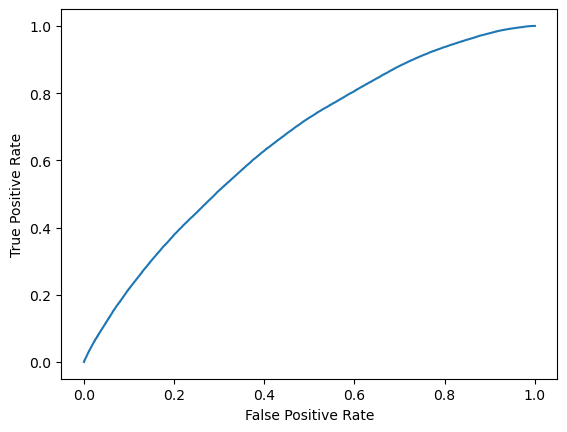

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, cbt.predict_proba(X_train)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [59]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.6585035111780204

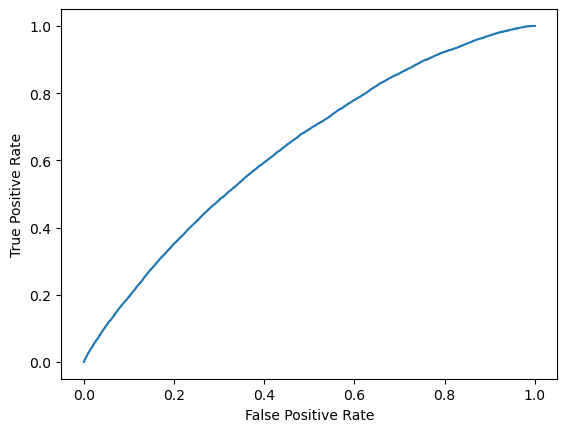

In [60]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, cbt.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [61]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.6370595892141707

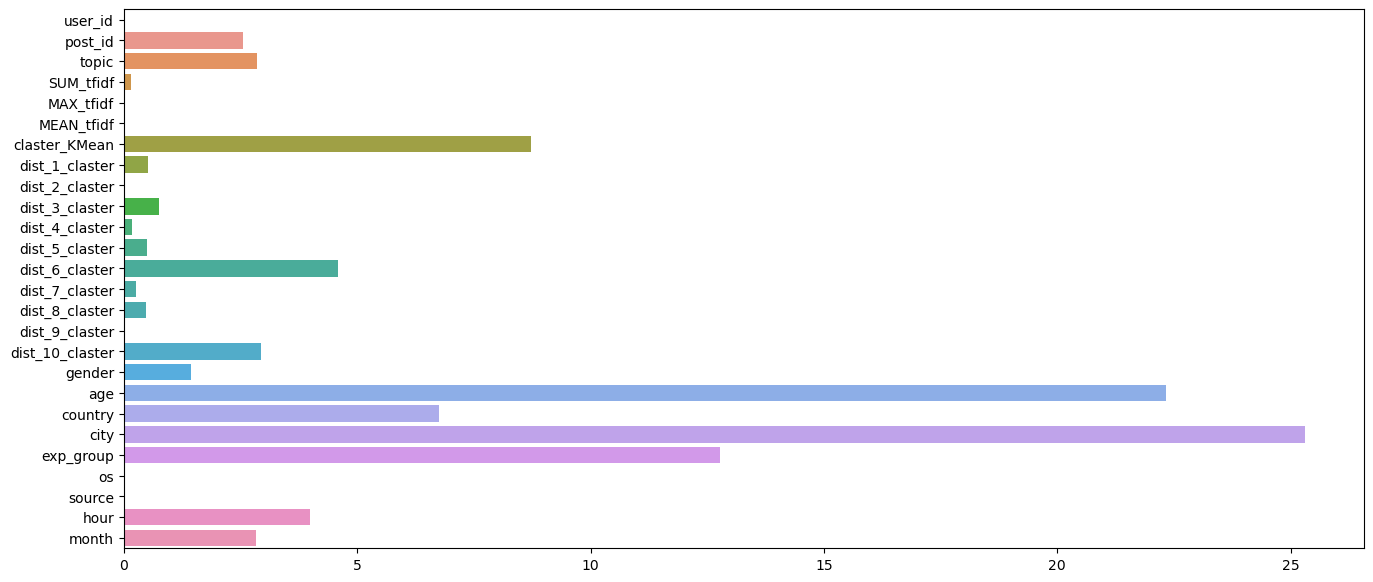

In [62]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(16, 7)

sns.barplot(x=cbt.feature_importances_,
           y=X_train.columns)

plt.show()

Text(0.5, 1.0, 'Feature Importance')

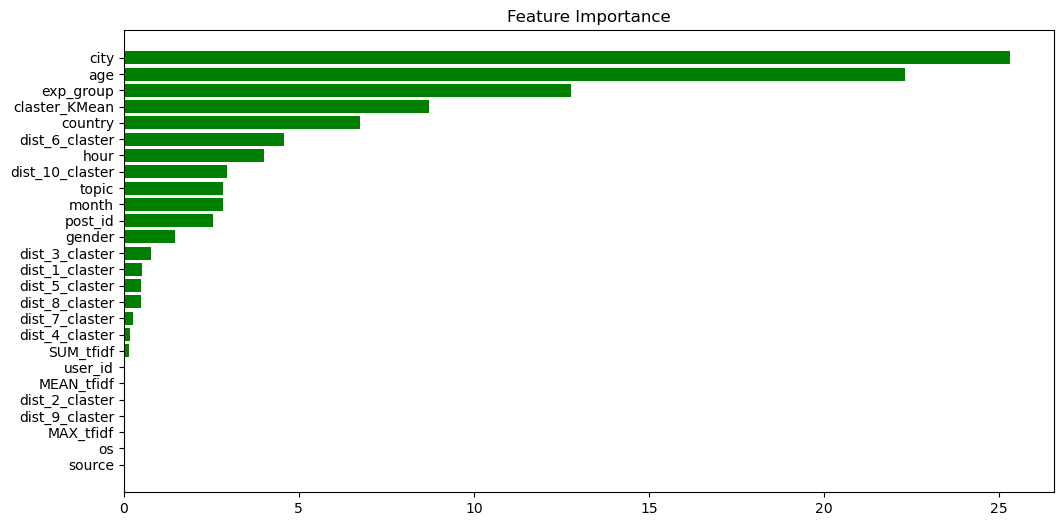

In [63]:
feature_importance = cbt.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = 'green')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')


In [64]:
cbt.save_model('catboost_model_proj_ml_last', format="cbm")

In [ ]:
import pandas as pd
posts = pd.read_sql(
    """SELECT * FROM public.velieva_posts""",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml")

In [ ]:
posts = posts.drop(['index'], axis = 1)

In [ ]:
posts

In [ ]:
posts.columns